In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import colorsys
import os
import imageio
import re
import itertools
import pandas as pd
import csv
import time

# Evolution functions

In [197]:
def network_evolution(state, t, W, alpha, omega, coupled_neuron, inputn):
    """
    Computes the derivatives of system parameters (densities and phases)
    
    :param state: np.array, vector of densities and phases (rho_1, rho_2, ..., rho_n, theta_1, ..., theta_n)
    :param t: float, current time
    :param W: np.array coupling matrix
    :param alpha: float, constant parameter
    :param omega: np.array, vector of frequencies
    :return: np.array, derivatives of state (input like)
    """
    N = int(len(state)/2)
    dstate_dt = np.zeros_like(state)
    coupled_values_den = state[coupled_neuron]
    coupled_values_phase = state[N+coupled_neuron]
    for neuron in range(N):
        if neuron in inputn: # evolves densities only for input neurons
            #dden_dt = -alpha*state[neuron]*state[neuron]*state[neuron]
            #dden_dt += np.sum(W[neuron]*coupled_values_den*np.cos(coupled_values_phase-state[N+neuron]))
            dden_dt = 0
            dstate_dt[neuron] = dden_dt
            dstate_dt[N+neuron] = 0
        else:
            dden_dt = -alpha*state[neuron]*state[neuron]*state[neuron]
            dden_dt += np.sum(W[neuron]*coupled_values_den*np.cos(coupled_values_phase-state[N+neuron]))

            dphase_dt = omega[neuron] + np.sum(W[neuron]*coupled_values_den/state[neuron]*np.sin(coupled_values_phase-state[N+neuron]))

            dstate_dt[neuron] = dden_dt
            dstate_dt[N+neuron] = dphase_dt
    return dstate_dt

def network_evolution_nudge(state, t, W, alpha, omega, coupled_neuron, inputn, beta_den, beta_phase, target):
    """
    Computes the derivatives of system parameters (densities and phases) after nudge of dynamics
    
    :param state: np.array, vector of densities and phases (rho_1, rho_2, ..., rho_n, theta_1, ..., theta_n)
    :param t: float, current time
    :param W: np.array coupling matrix
    :param alpha: float, constant parameter
    :param omega: np.array, vector of frequencies
    :param beta_den: np.array, density nudge strength (zeros differentiate from output)
    :param beta_phase: np.array, phase nudge strength (zeros differentiate from output)
    :param target: np.array, target state
    :return: np.array, derivatives of state (input like)
    """
    N = int(len(state)/2)
    dstate_dt = np.zeros_like(state)
    coupled_values_den = state[coupled_neuron]
    coupled_values_phase = state[N+coupled_neuron]
    for neuron in range(N):
        if neuron in inputn:
            #dden_dt = -alpha*state[neuron]*state[neuron]*state[neuron]
            #dden_dt += np.sum(W[neuron]*coupled_values_den*np.cos(coupled_values_phase-state[N+neuron]))
            dden_dt = 0
            dstate_dt[neuron] = dden_dt
            dstate_dt[N+neuron] = 0
        else:
            dden_dt = -alpha*state[neuron]*state[neuron]*state[neuron]
            dden_dt += np.sum(W[neuron]*coupled_values_den*np.cos(coupled_values_phase-state[N+neuron]))
            dden_dt += - beta_den[neuron]*(state[neuron]-target[neuron])

            dphase_dt = omega[neuron] + np.sum(W[neuron]*coupled_values_den/state[neuron]*np.sin(coupled_values_phase-state[N+neuron]))
            dphase_dt += - beta_phase[neuron]*np.sin(state[N+neuron]-target[N+neuron])/(np.cos(state[N+neuron]-target[N+neuron])+1+1e-8)

            dstate_dt[neuron] = dden_dt
            dstate_dt[N+neuron] = dphase_dt 
    return dstate_dt

def save_array_to_file(array, filename="savepoint.txt"):
    """
    Appends a numpy array as a new line in a specified file.
    """
    with open(filename, "a") as file:
        # Convert the array to a string representation and append a newline
        file.write(" ".join(map(str, array.flatten())) + "\n")

def read_and_plot(filename="savepoint.txt", x_range=(0, 200), y_bins=50, x_bins=200, y_max=5, plot_title=""):
    """
    Reads arrays from a file, accumulates counts in 2D bins, and plots as a binplot.
    The y-axis is limited to either 5 or the highest y value in the data, whichever is lower.
    """
    # Initialize lists to accumulate all x and y values across arrays
    all_x = []
    all_y = []
    
    with open(filename, "r") as file:
        for line in file:
            # Convert the line to a numpy array of y-values
            y_array = np.array([float(num) for num in line.strip().split()])
            
            # Assuming x array is a sequence (0, 1, ..., len(y_array)-1) for each y_array
            x_array = np.arange(len(y_array))
            
            # Append these x and y values to the lists
            all_x.extend(x_array)
            all_y.extend(y_array)
    
    # Determine the effective maximum y limit
    actual_y_max = min(max(all_y), y_max)
    print(f"The effective y-axis maximum is set to: {actual_y_max}")
    
    # Compute the 2D histogram of counts, limiting y values to [min(all_y), actual_y_max]
    counts, xedges, yedges = np.histogram2d(
        all_x, all_y, bins=[x_bins, y_bins], range=[x_range, (min(all_y), actual_y_max)]
    )
    
    # Plot the resulting bin counts as a heatmap
    plt.figure(figsize=(8, 6))
    plt.title(plot_title)
    plt.imshow(counts.T, origin='lower', aspect='auto', cmap="viridis", 
               extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    plt.colorbar(label="Point Count")
    plt.ylim(0, actual_y_max)  # Set y-axis limit to effective maximum
    plt.xlabel("epoch")  # Blank x-axis label
    plt.ylabel("value")  # Blank y-axis label
    plt.show()

# This function reads the arrays from the file, sums them, and plots the resulting binplot.

def find_amplitude_relative(N, neurons, weights, accuracy):
    amplitude_relative = 1
    
    T = 200
    dt = 0.01
    times = np.arange(0, T + dt, dt)
    alpha = 1.
    omega = np.zeros(N)

    # Placeholder to collect mean densities for each solution
    mean_densities = []

    # Step 1: Run 40 evolutions with random initialization
    for i in range(10):
        init_densities = np.array([np.random.uniform(-1, 1) / 2 for _ in neurons]) + amplitude_relative
        init_phases = np.array([np.random.uniform(-np.pi, np.pi) for _ in neurons])
        state = np.concatenate((init_densities, init_phases))

        # Solve the ODE to get the solution
        solution = odeint(network_evolution, state, times, args=(weights, alpha, omega, connections_neuronwise, inputn), full_output=0)
        
        # Collect the mean density for this solution (mean of first N elements)
        densities = solution[:, :N]
        mean_density = np.mean(densities)
        mean_densities.append(mean_density)

    # Step 2: Calculate the mean density value of mean densities
    overall_mean_density = np.mean(mean_densities)

    # Step 3 & 4: Iterate based on "accuracy" value
    for _ in range(accuracy):
        # Update labels_amp and features_amps based on the current amplitude_relative
        labels_amp = np.array([-1, 1, 1, -1]) / 2 + amplitude_relative
        features_amps = np.array([
            [-1, -1],
            [1, -1],
            [-1, 1],
            [1, 1]
        ]) / 2 + amplitude_relative

        for feature_amp in features_amps:
            # Distribute using feature_amp with distribution 0.5 around the mean point
            init_densities = np.array([np.random.uniform(-0.5, 0.5) for _ in neurons]) + overall_mean_density
            init_densities[0] = feature_amp[0]  # Set init_densities[0] to corresponding value of features_amps
            init_densities[1] = feature_amp[1]  # Set init_densities[1] to corresponding value of features_amps
            init_phases = np.array([np.random.uniform(-np.pi, np.pi) for _ in neurons])
            state = np.concatenate((init_densities, init_phases))

            # Step 5: Run 10 evolutions to refine the mean amplitude_relative
            for _ in range(3):
                solution = odeint(network_evolution, state, times, args=(weights, alpha, omega, connections_neuronwise, inputn), full_output=0)
                densities = solution[:, :N]
                mean_density = np.mean(densities)

                # Update amplitude_relative based on new mean_density
                amplitude_relative = mean_density
                
    return features_amps, labels_amp, amplitude_relative


def run_from_nothing(N=5, number_of_epochs=300, learning_rate=0.1, do_normalize=False, do_debug=False, connections_neuronwise=None, amplitude_relative=None):

    # preamble
    neurons = np.arange(0,N,1) 
    outputn = 2 
    inputn = [0,1] 
    if connections_neuronwise==None:
        connections_neuronwise = np.array([[element for element in neurons if element != neuron] for neuron in neurons]) 

    weights_matrix = np.zeros((N,N)) 
    for i in range(1,N):
        for j in range(0,i):
            weights_matrix[i][j] = np.random.normal(loc=0, scale=1)
            weights_matrix[j][i] = weights_matrix[i][j]
    weights = weights_matrix[connections_neuronwise, np.arange(N)[:, None]] 
    alpha = 1. 
    omega = np.zeros(N) 

    gradient_weights_forward = np.zeros((N,N))
    gradient_weights_backward = np.zeros((N,N))
    weight_gradient = np.zeros((N,N))

    beta_den = np.zeros(N)
    beta_den[outputn] = 1e-6

    batch_size = 4
    random_init_times = 1
    inv_nudge_step_den = 1/beta_den[outputn]
    inv_batch_size = 1/batch_size
    inv_random_init_times = 1/random_init_times

    if amplitude_relative==None:
        features_amp, labels_amp, amplitude_relative = find_amplitude_relative(N, neurons, weights, 2)
    else:
        features_amp = np.array([
        [-1,-1],
        [1,-1],
        [-1,1],
        [1,1]
        ])/2 + amplitude_relative
        labels_amp = np.array([-1,1,1,-1])/2 + amplitude_relative 

    T = 200
    dt = 0.01
    times = np.arange(0, T+dt, dt)

    init_densities = np.array([np.random.uniform(-1, 1)/2 for _ in neurons]) + amplitude_relative
    init_phases = np.array([np.random.uniform(-np.pi, np.pi) for _ in neurons])

    state = np.concatenate((init_densities, init_phases))

    distances_amp = []
    accuracies = []

    # training loop

    for epoch in range(number_of_epochs):
        time0 = time.time()
        if epoch%10 == 0:
            print(f"Starting epoch number {epoch}")

        weight_gradient = np.zeros((N,N))
        
        distance_amp_temp = []
        accuracies_temp = []
        for feature_amp, label_amp in zip(features_amp, labels_amp):
            
            target = np.zeros(2*N)
            target[outputn] = label_amp

            densities = np.copy(init_densities)
            phases = np.array([np.random.uniform(-np.pi, np.pi) for _ in neurons])
            densities[inputn[0]] = feature_amp[0]
            densities[inputn[1]] = feature_amp[1]
            phases[inputn[0]] = feature[0]
            phases[inputn[1]] = feature[1]
            state = np.concatenate((densities, phases))

            # calculating inference and inference energy
            states = odeint(network_evolution, state, times, args=(weights, alpha, omega, connections_neuronwise, inputn), full_output=0)

            phases = states[-1][N:2*N]
            densities = states[-1][0:N]
            state = np.concatenate((densities, phases)) # I forgot to add this before, checking solution requires attention to this detail

            # calculating distance and cost
            distance_amp_temp.append(np.abs(densities[outputn]-label_amp))
            if label_amp > amplitude_relative:
                accuracies_temp.append(densities[outputn]>amplitude_relative)
            else:
                accuracies_temp.append(densities[outputn]<amplitude_relative)

            # calculating for mean values (in case of oscillations or other symmetric events)
            #phases = np.mean([state[N:2*N] for state in states], axis=0)
            #densities = np.mean([state[0:N] for state in states], axis=0)

            # calculating energy gradient over weights
            for i in range(1,N):
                for j in range(0,i):
                    gradient_weights_forward[i][j] = -densities[i]*densities[j]*np.cos(phases[i]-phases[j])
                    gradient_weights_forward[j][i] = gradient_weights_forward[i][j]
            
            # calculating nudge of inference and its energy
            states_back = odeint(network_evolution_nudge, state, times, args=(weights, alpha, omega, connections_neuronwise, inputn, beta_den, beta_phase, target), full_output=0)

            phases = states_back[-1][N:2*N]
            densities = states_back[-1][0:N]

            #phases = np.mean([state[N:2*N] for state in states_back], axis=0)
            #densities = np.mean([state[0:N] for state in states_back], axis=0)

            for i in range(1,N):
                for j in range(0,i):
                    gradient_weights_backward[i][j] = -densities[i]*densities[j]*np.cos(phases[i]-phases[j])
                    gradient_weights_backward[j][i] = gradient_weights_backward[i][j]
            
            # calculating gradient
            weight_gradient += gradient_weights_backward - gradient_weights_forward
            # test_grad_vals.append(np.linalg.norm(gradient_weights_backward - gradient_weights_forward,ord=1))
        time1 = time.time()
        weight_gradient *= inv_batch_size*inv_random_init_times*inv_nudge_step_den
        distances_amp.append(np.sum(distance_amp_temp)/batch_size)
        accuracies.append(np.sum(accuracies_temp)/batch_size)

        # parameter updates
        #weight_gradient *= (inv_nudge_step_den+inv_nudge_step_phase) * inv_batch_size * inv_random_init_times

        # normalization (required for first few steps)
        
        #if np.linalg.norm(weight_gradient, ord=2)>5:
        if do_debug: 
            print(f"epoch {epoch},\ttime elapsed: {time1-time0}, gradient size {np.linalg.norm(weight_gradient,ord=1)}")
        if time1-time0>10:
            print("time exceeded critical amount")
            break
        if do_normalize: #np.linalg.norm(weight_gradient,ord=1) > 1* N*N:
            #print(f"gradient absolute size exceeded expected value\nL(∇W) = {np.linalg.norm(weight_gradient, ord=1)}")
            #print("NORMALIZED!")
            weight_gradient /= np.linalg.norm(weight_gradient,ord=1)
        
        

        weights_matrix -= learning_rate * weight_gradient
        weights = weights_matrix[connections_neuronwise, np.arange(N)[:, None]]

    #do_save = input("Do you want to save the distances and accuracies y/n:\t")
    
    return distances_amp, accuracies

# Network parameters

In [69]:
N = 7 # number of neurons
neurons = np.arange(0,N,1) #
outputn = 2 #output neuron
inputn = [0,1] # input neurons
connections_neuronwise = np.array([[element for element in neurons if element != neuron] for neuron in neurons]) # connections between neurons

weights_matrix = np.zeros((N,N)) # defining weights and initializing for lookup
for i in range(1,N):
    for j in range(0,i):
        weights_matrix[i][j] = np.random.normal(loc=0, scale=1)
        weights_matrix[j][i] = weights_matrix[i][j]
weights = weights_matrix[connections_neuronwise, np.arange(N)[:, None]] # defining weights for direct use
alpha = 1. # defining alpha parameter
omega = np.zeros(N) # defining frequencies (for now 0's)

# Dataset
XOR with:

$0\rightarrow -\pi/2$

$1\rightarrow \pi/2$

for $\theta$ and:

$1.5\rightarrow -1$

$0.5\rightarrow 1$

for $\rho$


In [70]:
amplitude_relative = 1
features_converted = np.array([
        [-np.pi,-np.pi],
        [np.pi,-np.pi],
        [-np.pi,np.pi],
        [np.pi,np.pi]
    ])/2
features_amp = np.array([
    [-1,-1],
    [1,-1],
    [-1,1],
    [1,1]
])/2 + amplitude_relative

labels_converted = np.array([-np.pi,np.pi,np.pi,-np.pi])/2
labels_amp = np.array([-1,1,1,-1])/2 + amplitude_relative 
features_original = np.array([[0,0],[1,0],[0,1],[1,1]])
features_original_label = ["0,0","1,0","0,1","1,1"]
labels_original = np.array([0,1,1,0])

In [127]:
neurons = np.arange(0,N,1) 
outputn = 2 
inputn = [0,1] 
connections_neuronwise = np.array([[element for element in neurons if element != neuron] for neuron in neurons]) 

weights_matrix = np.zeros((N,N)) 
for i in range(1,N):
    for j in range(0,i):
        weights_matrix[i][j] = np.random.normal(loc=0, scale=1)
        weights_matrix[j][i] = weights_matrix[i][j]
weights = weights_matrix[connections_neuronwise, np.arange(N)[:, None]] 
alpha = 1. 
omega = np.zeros(N) 

gradient_weights_forward = np.zeros((N,N))
gradient_weights_backward = np.zeros((N,N))
weight_gradient = np.zeros((N,N))

beta_den = np.zeros(N)
beta_den[outputn] = 1e-6

batch_size = 4
random_init_times = 1
inv_nudge_step_den = 1/beta_den[outputn]
inv_batch_size = 1/batch_size
inv_random_init_times = 1/random_init_times

features_amps, labels_amp, amplitude_relative = find_amplitude_relative(N, neurons, weights, 2)

In [128]:
features_amps, labels_amp, amplitude_relative

(array([[1.69249901, 1.69249901],
        [2.69249901, 1.69249901],
        [1.69249901, 2.69249901],
        [2.69249901, 2.69249901]]),
 array([1.69249901, 2.69249901, 2.69249901, 1.69249901]),
 3.0977965272842862)

# Learning parameters and initialization

In [105]:
gradient_weights_forward = np.zeros((N,N))
gradient_weights_backward = np.zeros((N,N))
weight_gradient = np.zeros((N,N))
# holds normalised values of each gradient after 1 inference (used for debugging)
test_grad_vals = []

learning_rate = 0.1

beta_den = np.zeros(N)
beta_phase = np.zeros(N)
# beta den doesn't partake in information processing directly, so respective cost function is ommited
beta_den[outputn] = 1e-6
beta_phase[outputn] = 1e-6

batch_size = 4
random_init_times = 1
if beta_den[outputn] != 0:
    inv_nudge_step_den = 1/beta_den[outputn]
inv_nudge_step_phase = 1/beta_phase[outputn]
inv_batch_size = 1/batch_size
inv_random_init_times = 1/random_init_times

T = 10
dt = 0.02
times = np.arange(0, T+dt, dt)

init_densities = np.array([np.random.uniform(-1, 1)/2 for _ in neurons]) + amplitude_relative
init_phases = np.array([np.random.uniform(-np.pi, np.pi) for _ in neurons])

state = np.concatenate((init_densities, init_phases))

num_of_epochs = 100
distances = []
distances_amp = []
costs = []
costs_amp = []

In [106]:
#state = np.array([10.,20.,30.,40.,50.,11.,12.,13.,14.,15.]) # test array for tests idk
omega = np.zeros(N)
import time
start_time = time.time()
revolt = odeint(network_evolution, state, times, args=(weights, alpha, omega, connections_neuronwise, inputn), full_output=0)
end_time = time.time()

operation_time = end_time - start_time
operation_time

0.060663461685180664

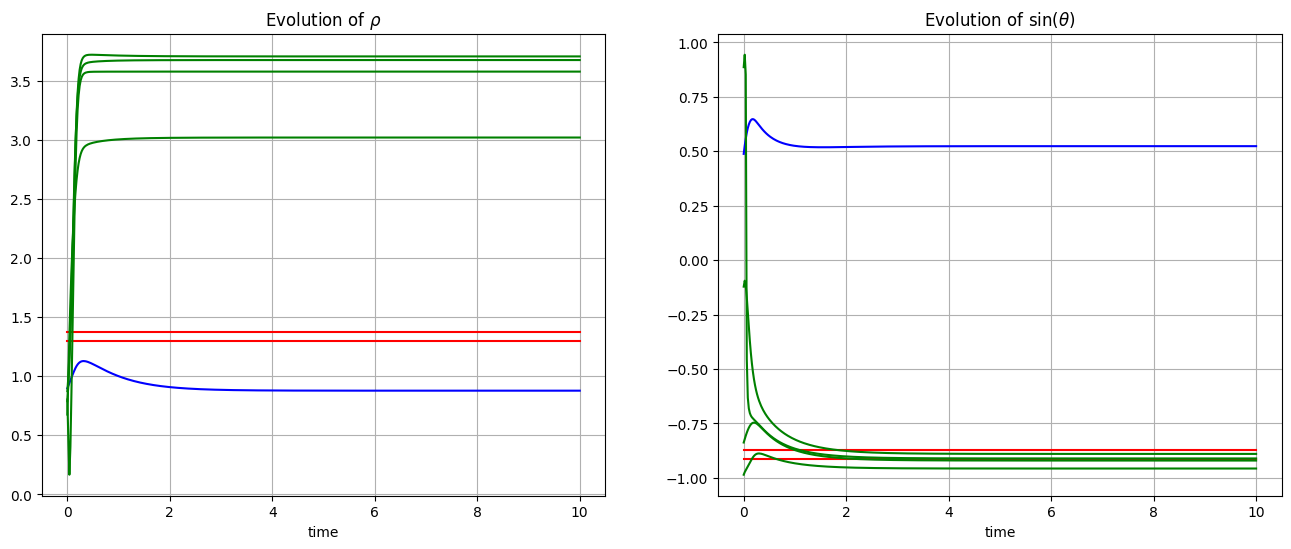

In [107]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16, 6)) 
colors = ['green'] * N  # Default to green for all indices
colors[inputn[0]] = 'red'
colors[inputn[1]] = 'red'
colors[outputn] = 'blue'
for j in range(N):
    axes[0].plot(times, revolt[:,j], color=colors[j])
axes[0].set_title(r"Evolution of $\rho$")
axes[0].set_xlabel("time")
axes[0].grid()

for j in range(N):
    axes[1].plot(times, np.sin(revolt[:,N+j]), color=colors[j])
axes[1].set_xlabel("time")
axes[1].grid()
axes[1].set_title(r"Evolution of $\sin(\theta)$")
plt.show()

# Inference and learning

In [108]:
T = 200
dt = 0.004
times = np.arange(0, T+dt, dt)

Starting epoch number 0
Starting epoch number 10
Starting epoch number 20
Starting epoch number 30
Starting epoch number 40


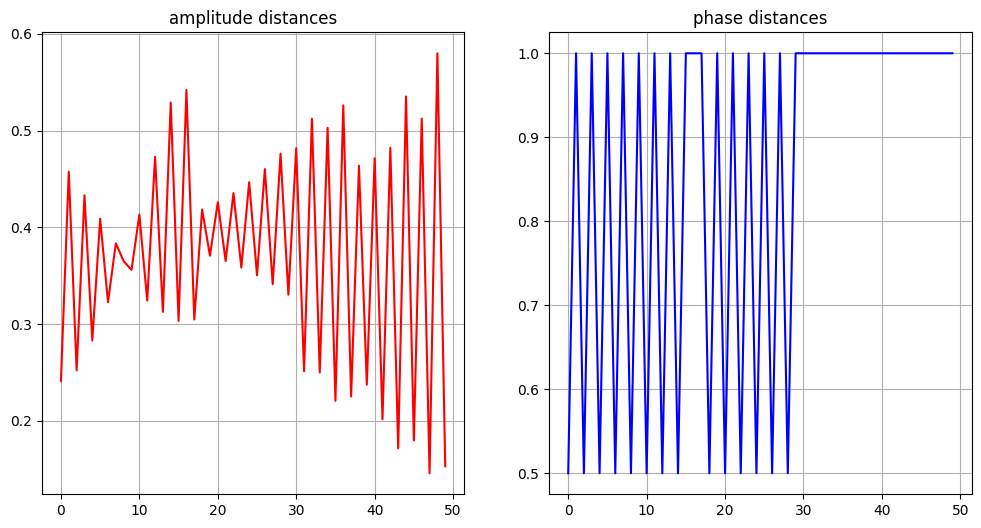

In [109]:
learning_rate = 0.3
num_of_epochs = 50

for epoch in range(num_of_epochs):

    if epoch%10 == 0:
        print(f"Starting epoch number {epoch}")

    weight_gradient = np.zeros((N,N))
    
    distance_temp = []
    distance_amp_temp = []
    cost_temp = []
    cost_amp_temp = []
    for feature, feature_amp, label, label_amp in zip(features_converted, features_amp, labels_converted, labels_amp):
        
        # for now target takes only
        target = np.zeros(2*N)
        target[outputn] = label_amp
        #target[N+outputn] = label

        # inserting input values and random initialization
        #densities = np.array([np.random.uniform(2.8, 3.2) for _ in neurons]) # maybe randomizing densities is wrong habit. To consider them like that I should encode information with them, this way they would be more than mobile parameters
        densities = np.copy(init_densities)
        phases = np.array([np.random.uniform(-np.pi, np.pi) for _ in neurons])
        #phases = np.copy(init_phases)
        densities[inputn[0]] = feature_amp[0]
        densities[inputn[1]] = feature_amp[1]
        phases[inputn[0]] = feature[0]
        phases[inputn[1]] = feature[1]
        state = np.concatenate((densities, phases))

        # calculating inference and inference energy
        states = odeint(network_evolution, state, times, args=(weights, alpha, omega, connections_neuronwise, inputn), full_output=0)

        phases = states[-1][N:2*N]
        densities = states[-1][0:N]
        state = np.concatenate((densities, phases)) # I forgot to add this before, checking solution requires attention to this detail

        # calculating for mean values (in case of oscillations or other symmetric events)
        #phases = np.mean([state[N:2*N] for state in states], axis=0)
        #densities = np.mean([state[0:N] for state in states], axis=0)

        # calculating energy gradient over weights
        for i in range(1,N):
            for j in range(0,i):
                gradient_weights_forward[i][j] = -densities[i]*densities[j]*np.cos(phases[i]-phases[j])
                gradient_weights_forward[j][i] = gradient_weights_forward[i][j]
        
        # calculating nudge of inference and its energy
        states_back = odeint(network_evolution_nudge, state, times, args=(weights, alpha, omega, connections_neuronwise, inputn, beta_den, beta_phase, target), full_output=0)

        phases = states_back[-1][N:2*N]
        densities = states_back[-1][0:N]

        #phases = np.mean([state[N:2*N] for state in states_back], axis=0)
        #densities = np.mean([state[0:N] for state in states_back], axis=0)

        for i in range(1,N):
            for j in range(0,i):
                gradient_weights_backward[i][j] = -densities[i]*densities[j]*np.cos(phases[i]-phases[j])
                gradient_weights_backward[j][i] = gradient_weights_backward[i][j]
        
        # calculating gradient
        weight_gradient += gradient_weights_backward - gradient_weights_forward
        # test_grad_vals.append(np.linalg.norm(gradient_weights_backward - gradient_weights_forward,ord=1))

        # calculating distance and cost
        distance_temp.append(1-np.cos(phases[outputn]-label))
        distance_amp_temp.append(np.abs(densities[outputn]-label_amp))
        cost_temp.append(-np.log(1+np.cos(phases[outputn]-label)))
        cost_amp_temp.append((densities[outputn] - label_amp)*(densities[outputn] - label_amp))
    
    weight_gradient *= inv_batch_size*inv_random_init_times*inv_nudge_step_phase
    distances.append(np.mean(distance_temp))
    distances_amp.append(np.mean(distance_amp_temp))
    costs.append(np.mean(cost_temp))
    costs.append(np.mean(cost_amp_temp))
    test_grad_vals.append(np.linalg.norm(weight_gradient,ord=1)/4)
    # parameter updates
    #weight_gradient *= (inv_nudge_step_den+inv_nudge_step_phase) * inv_batch_size * inv_random_init_times

    # normalization (required for first few steps)
    
    #if np.linalg.norm(weight_gradient, ord=2)>5:
    if True: #np.linalg.norm(weight_gradient,ord=1) > 1* N*N:
        #print(f"gradient absolute size exceeded expected value\nL(∇W) = {np.linalg.norm(weight_gradient, ord=1)}")
        #print("NORMALIZED!")
        weight_gradient /= np.linalg.norm(weight_gradient,ord=1)
 
    

    weights_matrix -= learning_rate * weight_gradient
    weights = weights_matrix[connections_neuronwise, np.arange(N)[:, None]]

fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
axes[0].plot(distances_amp, label="amplitude", c="r")
axes[0].set_title("amplitude distances")
axes[0].grid()
axes[1].plot(distances, c="b")
axes[1].set_title("phase distances")
axes[1].grid()
plt.savefig("XOR_SLNN_distances.png")
plt.show()

#do_save = input("Do you want to save the distances and accuracies y/n:\t")
if False:
    append_to_csv("XOR_SLNN_distances.csv", distances)

# Pure inference:

In [102]:
distance_temp = []
distance_amp_temp = []
cost_temp = []
outphase_temp = []
states_temp = []

for feature, feature_amp, label, label_amp in zip(features_converted, features_amp, labels_converted, labels_amp):
    target = np.zeros(2*N)
    target[N+outputn] = label

    # initial randomization
    #densities = np.array([np.random.uniform(0.5, 1.5) for _ in neurons])
    densities = np.copy(init_densities)
    phases = np.array([np.random.uniform(-np.pi, np.pi) for _ in neurons])
    #phases = np.copy(init_phases)
    densities[inputn[0]] = feature_amp[0]
    densities[inputn[1]] = feature_amp[1]
    phases[inputn[0]] = feature[0]
    phases[inputn[1]] = feature[1]
    state = np.concatenate((densities, phases))
    
    states = odeint(network_evolution, state, times, args=(weights, alpha, omega, connections_neuronwise, inputn), full_output=0)

    phases = states[-1][N:2*N]
    densities = states[-1][0:N]

    states_temp.append(states)
    distance_temp.append(1-np.cos(phases[outputn]-label))
    distance_amp_temp.append(np.abs(densities[outputn]-label_amp))
    if phases[outputn]-label == 0:
        cost_temp.append(0)
    else:
        cost_temp.append(-np.log(1+np.cos(phases[outputn]-label)))
    outphase_temp.append(phases[outputn])

/tmp/ipykernel_208444/3955168000.py:33: RuntimeWarning: divide by zero encountered in log
  cost_temp.append(-np.log(1+np.cos(phases[outputn]-label)))


### Output is blue, hidden neurons are green, input neurons are red

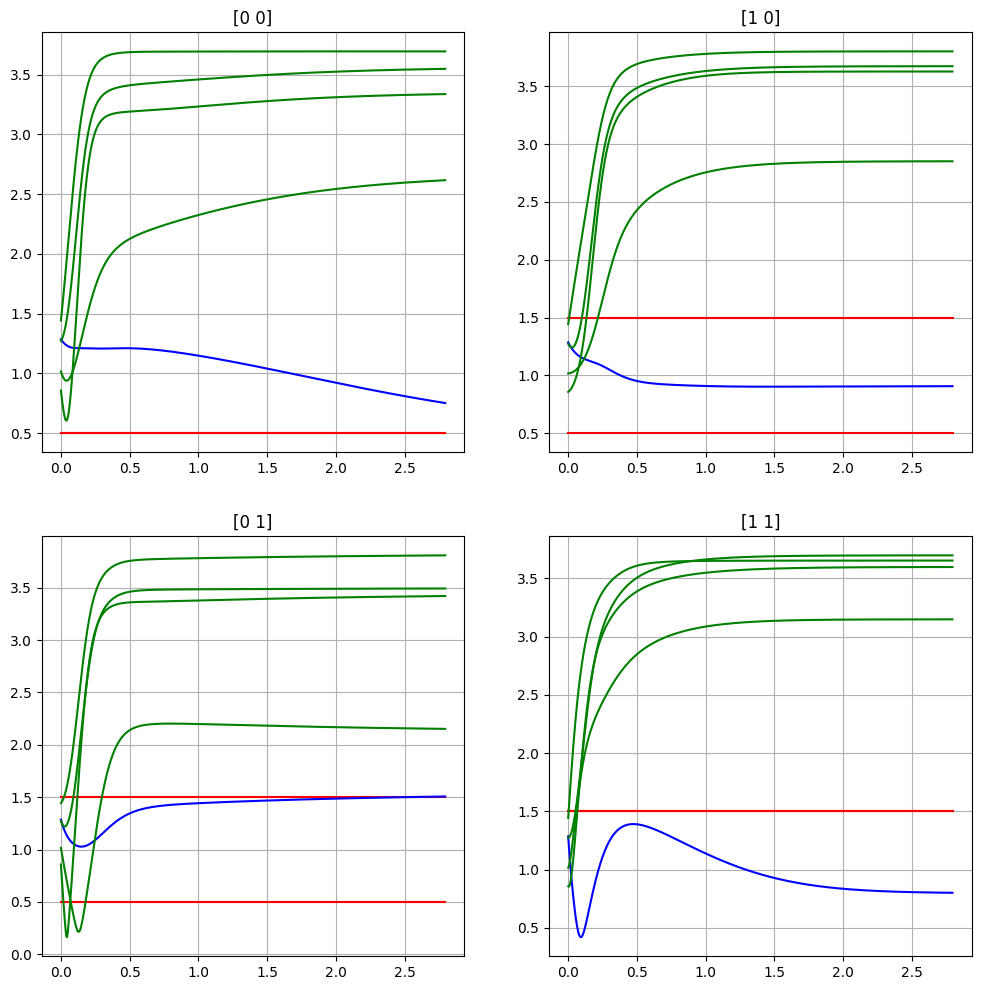

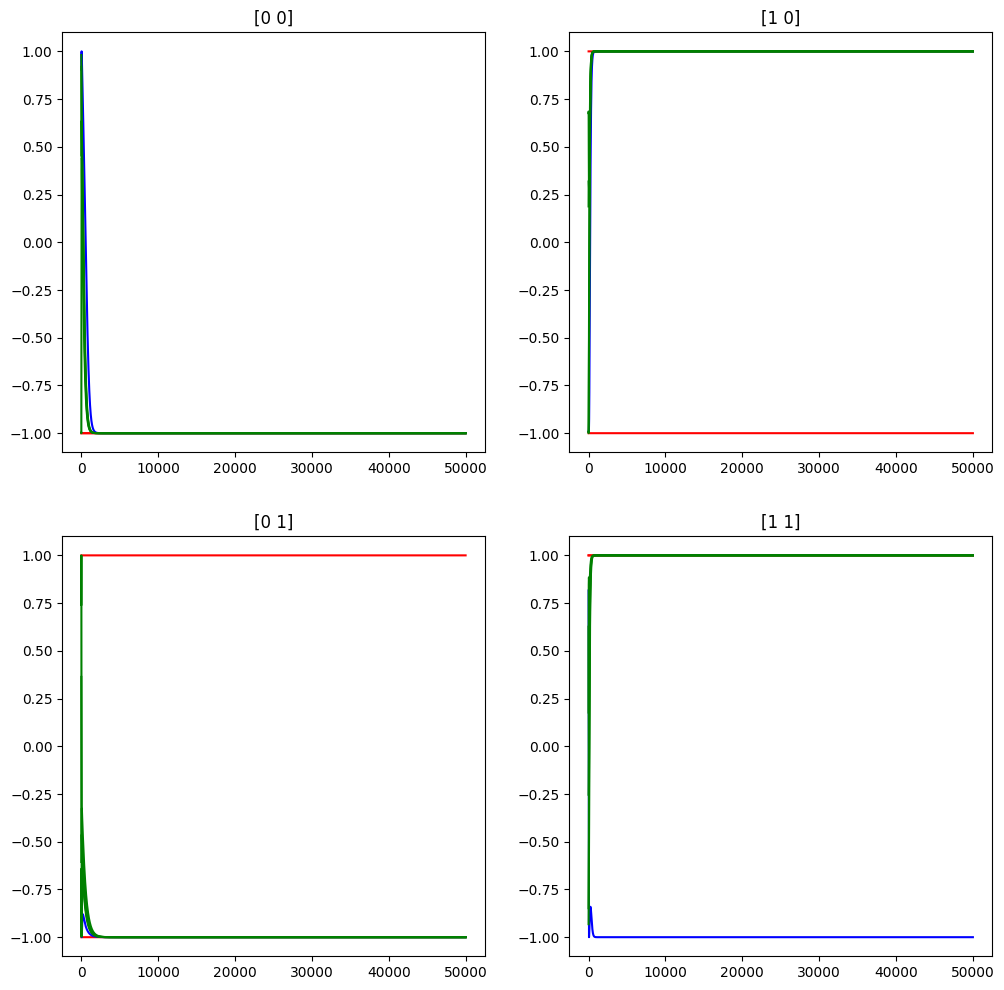

In [177]:
# Densities
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 12)) 

for i, ax in enumerate(axes.flatten()):
    # Initialize an array for colors based on indices
    colors = ['green'] * N  # Default to green for all indices
    colors[inputn[0]] = 'red'
    colors[inputn[1]] = 'red'
    colors[outputn] = 'blue'

    # Plot each state with the assigned color
    for j in range(N):
        ax.plot(times[0:700], states_temp[i][:, j][0:700], color=colors[j])
        ax.grid()
    
    ax.set_title(features_original[i])

plt.show()
# Phases
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 12)) 

for i, ax in enumerate(axes.flatten()):
    # Initialize an array for colors based on indices
    colors = ['green'] * N  # Default to green for all indices
    colors[inputn[0]] = 'red'
    colors[inputn[1]] = 'red'
    colors[outputn] = 'blue'

    # Plot each sine-transformed state with the assigned color
    for j in range(N):
        ax.plot(np.sin(states_temp[i][:, j + N]), color=colors[j])
    
    ax.set_title(features_original[i])

plt.show()

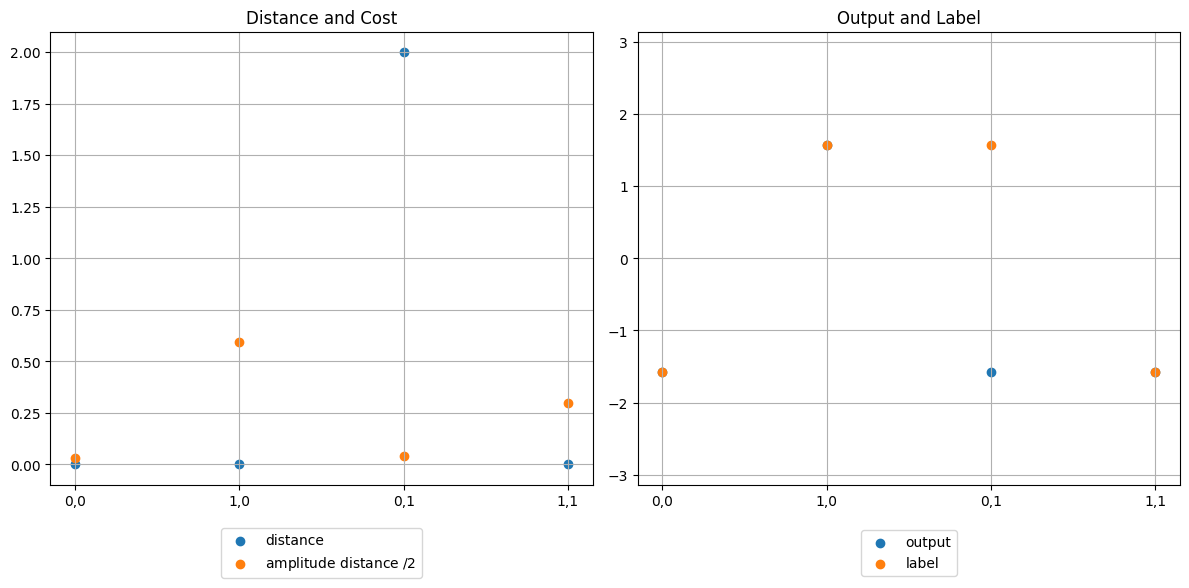

In [104]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))  # Create a figure with two subplots side by side
features_original_label = ["0,0","1,0","0,1","1,1"]
# First subplot (left side)
axes[0].scatter(features_original_label, distance_temp, label="distance")
axes[0].scatter(features_original_label, distance_amp_temp, label="amplitude distance $/2$")
axes[0].legend(loc='center', bbox_to_anchor=(0.5, -0.15))  # Center legend below the plot
axes[0].grid()
axes[0].set_title("Distance and Cost")

# Second subplot (right side)
axes[1].scatter(features_original_label, (np.array(outphase_temp) + np.pi) % (2 * np.pi) - np.pi, label="output")
axes[1].scatter(features_original_label, labels_converted, label="label")
axes[1].set_ylim([-np.pi, np.pi])
axes[1].grid()
axes[1].legend(loc='center', bbox_to_anchor=(0.5, -0.15))  # Center legend below the plot
axes[1].set_title("Output and Label")

plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()

In [180]:
"""
for _ in range(40):
        distances_amp, accuracies = run_from_nothing(N=7,number_of_epochs=200, learning_rate=0.1, do_normalize=True, do_debug=True, connections_neuronwise=None, amplitude_relative=1.)
        save_array_to_file(np.array(distances_amp), "XOR_SLNN_distances_7.txt")
        save_array_to_file(np.array(accuracies), "XOR_SLNN_accuracies_7.txt")
for _ in range(40):
        distances_amp, accuracies = run_from_nothing(N=6,number_of_epochs=200, learning_rate=0.1, do_normalize=True, do_debug=True, connections_neuronwise=None, amplitude_relative=1.)
        save_array_to_file(np.array(distances_amp), "XOR_SLNN_distances_6.txt")
        save_array_to_file(np.array(accuracies), "XOR_SLNN_accuracies_6.txt")
"""
for _ in range(20):
        distances_amp, accuracies = run_from_nothing(N=6,number_of_epochs=200, learning_rate=0.1, do_normalize=False, do_debug=False, connections_neuronwise=None, amplitude_relative=1.)
        save_array_to_file(np.array(distances_amp), "XOR_SLNN_distances_6_no_norm.txt")
        save_array_to_file(np.array(accuracies), "XOR_SLNN_accuracies_6_no_norm.txt")
for _ in range(20):
        distances_amp, accuracies = run_from_nothing(N=5,number_of_epochs=200, learning_rate=0.1, do_normalize=True, do_debug=True, connections_neuronwise=None, amplitude_relative=1.)
        save_array_to_file(np.array(distances_amp), "XOR_SLNN_distances_5.txt")
        save_array_to_file(np.array(accuracies), "XOR_SLNN_accuracies_5.txt")

Starting epoch number 0
Starting epoch number 10


/tmp/ipykernel_208444/2336129882.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  states = odeint(network_evolution, state, times, args=(weights, alpha, omega, connections_neuronwise, inputn), full_output=0)


Starting epoch number 20
Starting epoch number 30
Starting epoch number 40
Starting epoch number 50
Starting epoch number 60
Starting epoch number 70
Starting epoch number 80
Starting epoch number 90
Starting epoch number 100
Starting epoch number 110
Starting epoch number 120
Starting epoch number 130
Starting epoch number 140
Starting epoch number 150
Starting epoch number 160
Starting epoch number 170
Starting epoch number 180
Starting epoch number 190
Starting epoch number 0
Starting epoch number 10


/tmp/ipykernel_208444/2336129882.py:271: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  states_back = odeint(network_evolution_nudge, state, times, args=(weights, alpha, omega, connections_neuronwise, inputn, beta_den, beta_phase, target), full_output=0)


Starting epoch number 20
Starting epoch number 30
Starting epoch number 40
Starting epoch number 50
Starting epoch number 60
Starting epoch number 70
Starting epoch number 80
Starting epoch number 90
Starting epoch number 100
Starting epoch number 110
Starting epoch number 120
Starting epoch number 130
Starting epoch number 140
time exceeded critical amount
Starting epoch number 0
Starting epoch number 10
Starting epoch number 20
Starting epoch number 30
Starting epoch number 40
Starting epoch number 50
Starting epoch number 60
Starting epoch number 70
Starting epoch number 80
Starting epoch number 90
Starting epoch number 100
Starting epoch number 110
Starting epoch number 120
Starting epoch number 130
Starting epoch number 140
Starting epoch number 150
Starting epoch number 160
Starting epoch number 170
Starting epoch number 180
Starting epoch number 190
Starting epoch number 0
Starting epoch number 10
time exceeded critical amount
Starting epoch number 0
Starting epoch number 10
Sta

The effective y-axis maximum is set to: 2.1650397610341976


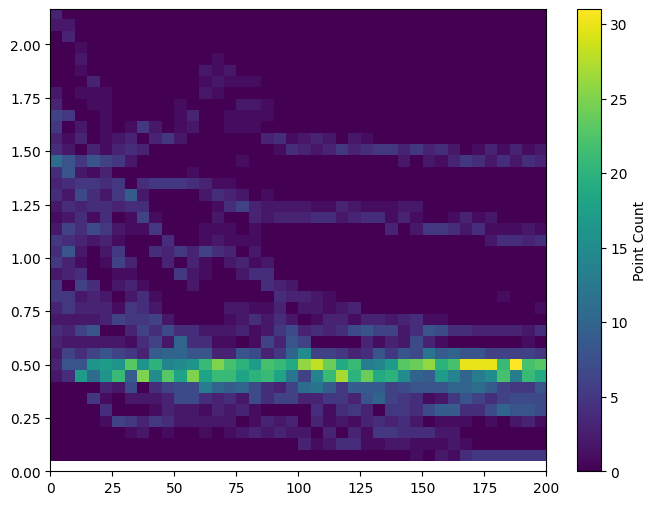

The effective y-axis maximum is set to: 1.0


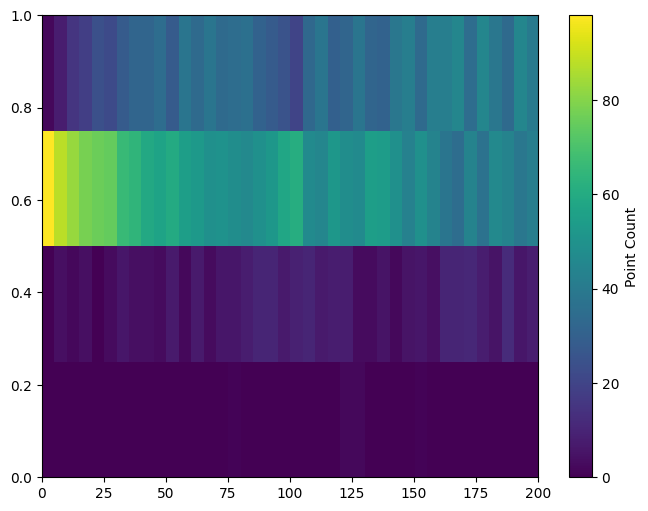

The effective y-axis maximum is set to: 3.5624983821372505


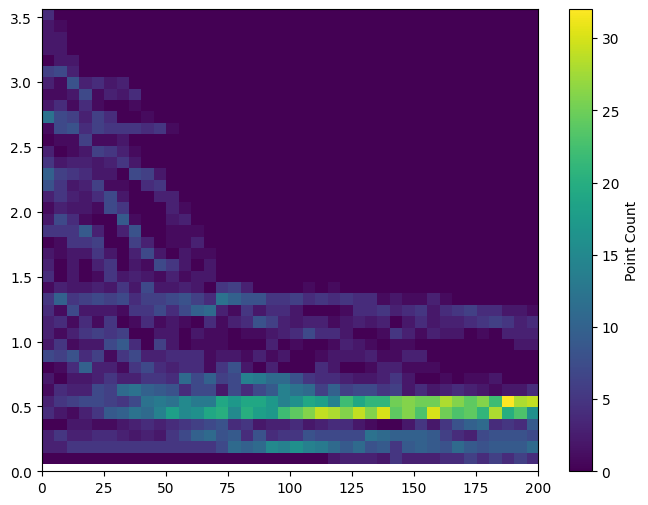

The effective y-axis maximum is set to: 1.0


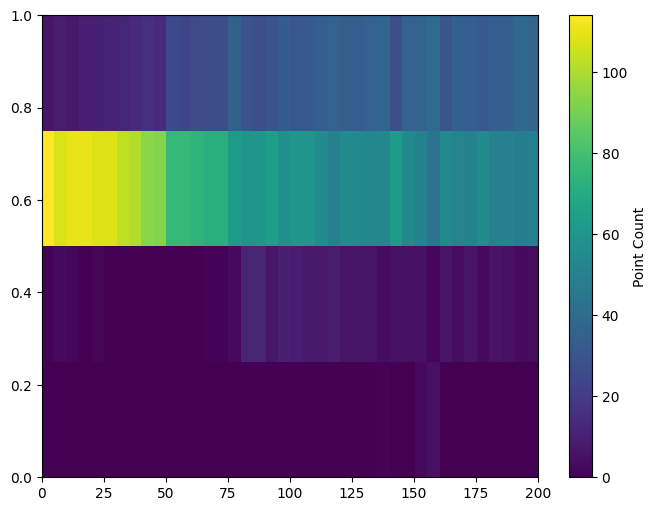

The effective y-axis maximum is set to: 5


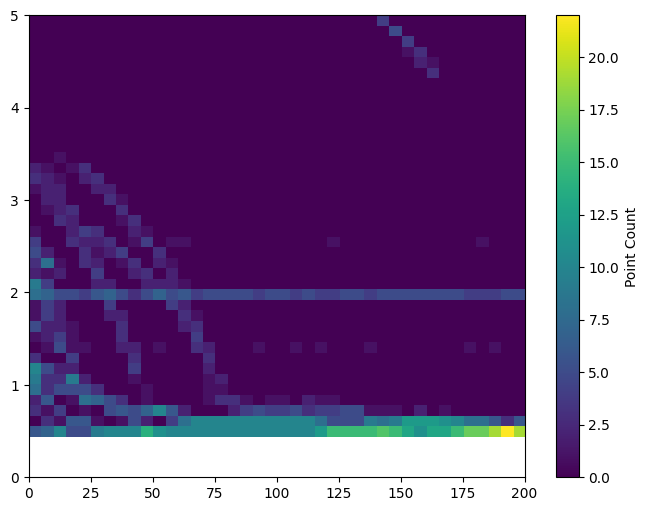

The effective y-axis maximum is set to: 0.75


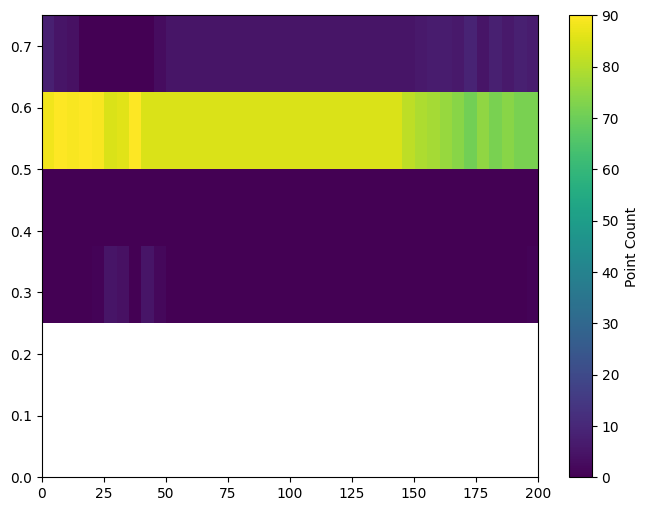

The effective y-axis maximum is set to: 4.314417563013295


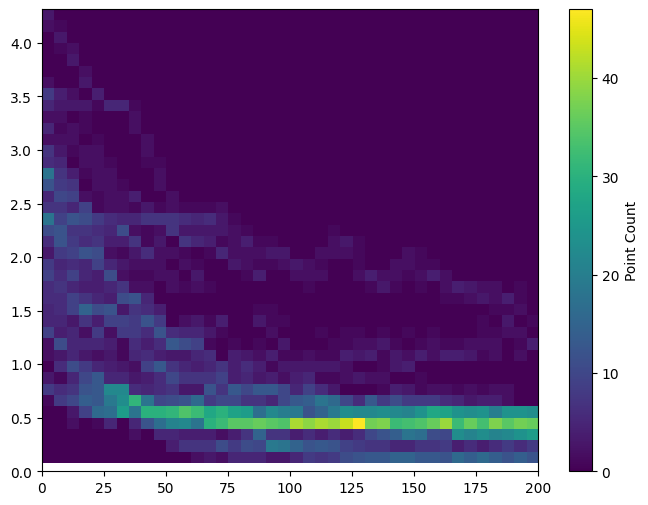

The effective y-axis maximum is set to: 1.0


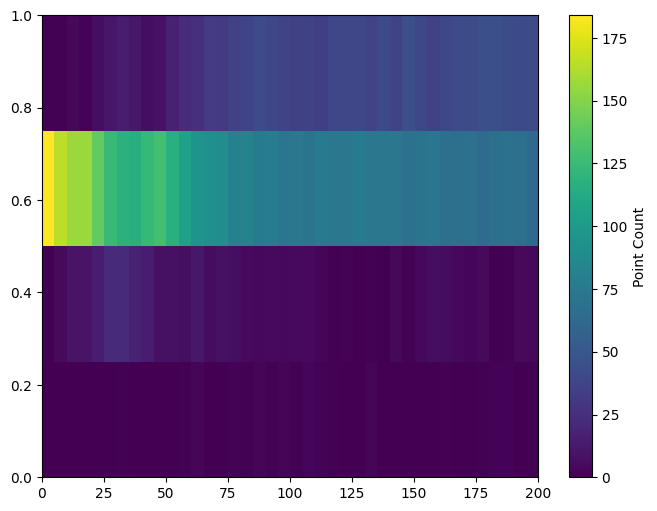

In [199]:
read_and_plot("XOR_SLNN_distances_5.txt", y_bins=40, x_bins=40, plot_title="5 neurons distances")
read_and_plot("XOR_SLNN_accuracies_5.txt", y_bins=4, x_bins=40, plot_title="5 neurons, accuracies")
read_and_plot("XOR_SLNN_distances_6.txt", y_bins=40, x_bins=40, plot_title="6 neurons distances")
read_and_plot("XOR_SLNN_accuracies_6.txt", y_bins=4, x_bins=40, plot_title="6 neurons accuracies")
read_and_plot("XOR_SLNN_distances_6_no_norm.txt", y_bins=40, x_bins=40, plot_title="6 neurons (no norm) distances")
read_and_plot("XOR_SLNN_accuracies_6_no_norm.txt", y_bins=4, x_bins=40, plot_title="6 neurons (no norm) accuracies")
read_and_plot("XOR_SLNN_distances_7.txt", y_bins=40, x_bins=40, plot_title="7 neurons distances")
read_and_plot("XOR_SLNN_accuracies_7.txt", y_bins=4, x_bins=40, plot_title="7 neurons accuracies")